In [1]:
import xarray as xr
import seawater as sw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import yaml
import os
from xhistogram.xarray import histogram as xhist
import seawater as gsw
from shapely.geometry import Polygon
import tqdm
from scipy.stats import linregress
import dask
import dask.distributed
import dask_jobqueue
from matplotlib.offsetbox import AnchoredText
import warnings

warnings.filterwarnings("ignore")

In [2]:
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4,
    memory="16GB",
    processes=1,  # Dask workers per job
    # SLURM job script things
    queue="base",
    walltime="04:00:00",
    # Dask worker network and temporary storage
    interface="ib0",
    local_directory="$TMPDIR",  # for spilling tmp data to disk
    log_directory="slurm/",
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15)  # 15
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.23:8787/status,
Dashboard: http://172.18.4.23:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.23:45667,Workers: 0
Dashboard: http://172.18.4.23:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def filter_beached_particles(ds, dim=None):
    # Identify particles that reach zero salinity
    particles_reach_zero_salinity = (ds.salt == 0).any(dim)

    # Identify particles that have not reached zero salinity (beached)
    particles_beached = ~particles_reach_zero_salinity

    # Filter the dataset to include only particles that have not reached zero salinity
    ds_particles_reach_zero_salinity_beached = ds.where(
        particles_beached.load(), drop=True
    )

    return ds_particles_reach_zero_salinity_beached


def compute_density(ds):
    ds_density = (
        xr.apply_ufunc(
            gsw.eos80.pden,
            ds.salt,
            ds.temp,
            0,
            dask="parallelized",
            output_dtypes=[np.float64],
        )
        - 1000
    )
    ds_add_dens = ds.assign(sigma0=ds_density)
    return ds_add_dens


def calc_min_max(ds):
    lon_min = float(ds.lon.min().values)
    lon_max = float(ds.lon.max().values)
    lat_min = float(ds.lat.min().values)
    lat_max = float(ds.lat.max().values)
    res = {
        "lon_min": lon_min,
        "lon_max": lon_max,
        "lat_min": lat_min,
        "lat_max": lat_max,
    }
    return res


def filter_particles_by_density(ds, density_threshold, dim=None):
    # Identify particles with density less than the threshold
    particles_less_than_threshold = (ds.sigma0 < density_threshold).any(dim)

    # Identify particles that reach or exceed the threshold
    particles_that_reach_threshold = ~particles_less_than_threshold

    # Filter the dataset to include only particles that exceed the threshold
    ds_particles_greater_than_threshold = ds.where(
        particles_that_reach_threshold.compute(), drop=True
    )

    return ds_particles_greater_than_threshold


hours_to_days = 0.0416667
hours_to_months = 0.00136986
hours_to_years = 0.000114155
time_conversion = hours_to_days
velocity_conversion = (
    1852 * 60
)  # multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)


def rechunk_for_hist(var):
    return var.chunk({"trajectory": 50, "obs": -1})


# rechunk lat and lon
def rechunk_lat_lon(ds):
    lon_rechunk = rechunk_for_hist(ds["lon"])
    lat_rechunk = rechunk_for_hist(ds["lat"])

    return lon_rechunk, lat_rechunk


def get_mean_maps(ds, lon_rechunk, lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(
        lon_rechunk,
        lat_rechunk,
        bins=[lon_bins, lat_bins],
        weights=ds,
        dim=["obs", "trajectory"],
    )
    counts = xhist(
        lon_rechunk,
        lat_rechunk,
        bins=[lon_bins, lat_bins],
        weights=weights,
        dim=["obs", "trajectory"],
    )
    mean_temp = weighted_sum / counts
    return mean_temp

In [4]:
# converting the age from nano seconds
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/Data/"
hours_to_days = 0.0416667
hours_to_months = 0.00136986
hours_to_years = 0.000114155
time_conversion = hours_to_days
velocity_conversion = (
    1852 * 60
)  # multiply the value of the V field with 1852 * 60 (the number of meters in 1 degree of latitude)

mesh_mask = xr.open_dataset(inpath + "mesh_masks/mesh_mask.nc")
mesh_hzgr = xr.open_dataset(inpath + "mesh_masks/mesh_hzgr.nc")
mesh_hgr = xr.open_dataset(inpath + "mesh_masks/mesh_hgr.nc")

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point
bathymetry = (
    (z * t_mask)
    .isel(t=0)
    .sum(dim="z")
    .assign_coords({"nav_lat": mesh_hgr.nav_lat, "nav_lon": mesh_hgr.nav_lon})
)

# turn zeros into nans, easier to see where continents are
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask != 0).isel(t=0, z=0)

In [5]:
ds_orig = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/data/level2/corrected_1995_2020_parcels_releases_seed-2345.zarr",
    engine="zarr",
    chunks="auto",
)


ds_orig = filter_beached_particles(ds_orig, "obs")
ds_orig = compute_density(ds_orig)

ds_overflows = filter_particles_by_density(ds_orig, 27.8, "obs")

ds_overflows = ds_overflows.where(ds_overflows.age * hours_to_years > -10, drop=False)

p = ds_overflows
p["start_time"] = p.isel(obs=0).time
p = p.set_coords("start_time")
p = p.set_xindex("start_time")

In [6]:
outdir = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/data/level3/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f"{outdir}/minmax.yaml"):
    with open(f"{outdir}/minmax.yaml", "r") as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds_overflows)
    with open(f"{outdir}/minmax.yaml", "w") as file:
        yaml.dump(results, file)

n = 0.25  # .25
lon_bins = np.arange(results["lon_min"], results["lon_max"], n)
lat_bins = np.arange(results["lat_min"], results["lat_max"], n)

In [7]:
def calculate_slope_intercept(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b


def process_ocean_basins(bathy):
    # Lofoten
    # m, b = calculate_slope_intercept(-4.5,70.7,2,68.4)
    # m3, b3 = calculate_slope_intercept(9,68.4,14,69.6)
    # m4, b4 = calculate_slope_intercept(6,72.5,-4.5,70.7)
    # m5,b5 = calculate_slope_intercept(14,69.6,6,72.5)

    m, b = calculate_slope_intercept(-4.5, 70.7, 2, 68.6)
    m3, b3 = calculate_slope_intercept(9, 68.6, 14, 69.6)
    m4, b4 = calculate_slope_intercept(6, 72.5, -4.5, 70.7)
    m5, b5 = calculate_slope_intercept(14, 69.6, 6, 72.5)

    ds_window = bathy.lat >= bathy.lon * m + b
    ds_window2 = bathy.lat >= 68.6
    ds_window3 = bathy.lat >= bathy.lon * m3 + b3
    ds_window4 = bathy.lat <= bathy.lon * m4 + b4
    ds_window5 = bathy.lat <= bathy.lon * m5 + b5

    lofoten = (ds_window & ds_window2 & ds_window3 & ds_window4 & ds_window5).astype(
        int
    )
    lofoten = xr.where(lofoten > 0, 1, 0).astype(int)
    lofoten = bathy.where(lofoten, drop=False)

    # Greenland sea
    m, b = calculate_slope_intercept(-12, 74.5, -2.5, 76.7)
    m2, b2 = calculate_slope_intercept(-2.5, 76.7, 4, 74)
    m3, b3 = calculate_slope_intercept(4, 74, -1, 73)

    ds_window = bathy.lat <= bathy.lon * m + b
    ds_window2 = bathy.lat <= bathy.lon * m2 + b2
    ds_window3 = bathy.lat >= bathy.lon * m3 + b3
    ds_window4 = bathy.lat >= 73
    ds_window5 = bathy.lon >= -12
    gsea = (ds_window & ds_window2 & ds_window3 & ds_window4 & ds_window5).astype(int)
    gsea = xr.where(gsea > 0, 1, 0).astype(int)
    gsea = bathy.where(gsea, drop=False)

    # Iceland sea
    # m2, b2 = calculate_slope_intercept(-12.5, 66.5,-14, 67.5)
    # ds_window = bathy.lat >= 66.5
    # ds_window2 = bathy.lat >= bathy.lon * m2 + b2
    # ds_window3 = bathy.lon <= -8.75
    # ds_window4 = bathy.lat <= 70.2
    # ds_window5 = bathy.lon >= -14
    # isea = (ds_window & ds_window2 & ds_window5 & ds_window3 & ds_window4).astype(int) # & ds_window2 & ds_window3 & ds_window4
    # isea = xr.where(isea > 0, 1, 0).astype(int)
    # isea = bathy.where(isea, drop=False)
    isea_box = (
        (bathy.lon > -13.5) & (bathy.lat > 67.5) & (bathy.lon < -9.2) & (bathy.lat < 70)
    )  # lon > -14
    isea = bathy.where(isea_box, drop=False)

    # norwegian basin
    m2, b2 = calculate_slope_intercept(-3, 69.5, 1, 67.5)

    ds_window = bathy.lon >= -6.2
    ds_window2 = bathy.lat >= 64
    ds_window3 = bathy.lon <= 1
    ds_window4 = bathy.lat <= 69.5
    ds_window5 = bathy.lat <= bathy.lon * m2 + b2

    nbasin = (ds_window & ds_window2 & ds_window3 & ds_window4 & ds_window5).astype(int)
    nbasin = xr.where(nbasin > 0, 1, 0).astype(int)
    nbasin = bathy.where(nbasin, drop=False)

    return {"lofoten": lofoten, "greenland": gsea, "iceland": isea, "norwegian": nbasin}


def filter_trajectories(ds_line, ds_all_trajs):
    """
    filters trajectories based on whether they cross the line.

    parameters:
    ds_orig (xarray.Dataset): original dataset containing trajectory data.
    ds_line (xarray.Dataset): dataset containing the line information.

    returns:
    traj_not_line (xarray.Dataset): trajectories that do not cross the line.
    traj_line (xarray.Dataset): trajectories that cross the line.
    traj_all (xarray.Dataset): all trajectories from the original dataset.
    """

    nans_per_traj = (ds_line["temp"].isnull()).sum(dim="obs").compute()

    traj_not_line = ds_all_trajs.sel(
        trajectory=(nans_per_traj == ds_line.obs.size)
    )  # select all trajs with all nans, i.e. not crossing
    traj_line = ds_all_trajs.sel(
        trajectory=(nans_per_traj != ds_line.obs.size)
    )  # select all trajs with at least one non-nan, i.e. crossing

    traj_all = ds_all_trajs

    return {
        "traj_line": traj_line,
        "traj_not_line": traj_not_line,
        "traj_all": traj_all,
    }


def create_polygon(vertices):
    polygon = Polygon(vertices)
    x_coords, y_coords = polygon.exterior.xy
    return polygon, x_coords, y_coords


vertices_Gsea = [(-12, 74.5), (-2.5, 76.7), (4, 74), (-1, 73), (-12, 73), (-12, 74.5)]

vertices_Lofoten = [
    (-4.5, 70.7),
    (2, 68.6),
    (9, 68.6),
    (14, 69.6),
    (6, 72.5),
    (-4.5, 70.7),
]

vertices_Iceland = [(-13.5, 70), (-9.2, 70), (-9.2, 67.5), (-13.5, 67.5)]

vertices_Norwegian = [
    (-6.2, 64),
    (-6.2, 69.5),
    (-3, 69.5),
    (1, 67.5),
    (1, 64),
    (-6.2, 64),
]


# Create polygons and extract coordinates
polygon_Gsea, x_GSea, y_GSea = create_polygon(vertices_Gsea)
polygon_Lofoten, x_Lofoten, y_Lofoten = create_polygon(vertices_Lofoten)
polygon_Iceland, x_Iceland, y_Iceland = create_polygon(vertices_Iceland)
polygon_Norwegian, x_Norwegian, y_Norwegian = create_polygon(vertices_Norwegian)


def compute_probability_perc(traj_line_not_all):
    # Create a 2D histogram of the latitude and longitude
    heat_map_time_non = xhist(
        traj_line_not_all.lat,
        traj_line_not_all.lon,
        bins=[lat_bins, lon_bins],
        dim=["obs"],
        bin_dim_suffix="",
    )

    # Count unique trajectories in each bin
    heat_map_time_unique_non = (heat_map_time_non > 0).sum(dim="trajectory")

    # Calculate the percentage of trajectories in each bin
    heat_map_percentage_non = (
        heat_map_time_unique_non / ds_overflows.trajectory.size
    ) * 100

    # Compute the result
    heat_map_percentage_non_cp = heat_map_percentage_non.compute()

    return heat_map_percentage_non_cp


def calculate_heatmap(ds):
    heat_map = xhist(
        ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=["trajectory"], bin_dim_suffix=""
    )
    heat_map = heat_map.where(heat_map > 0)
    return heat_map


def compute_probability_weighted(traj_line_not_all):
    """
    Compute a heatmap where each bin counts how many particle positions occurred there,
    rather than only counting unique trajectories. This highlights regions where particles
    pass even if spread over a wide area.
    """
    # 2D histogram over lat/lon; sum over 'obs' (all recorded positions)
    heat_map_counts = xhist(
        traj_line_not_all.lat,
        traj_line_not_all.lon,
        bins=[lat_bins, lon_bins],
        dim=["obs"],
        bin_dim_suffix="",
    )

    # sum over trajectories to get total positions per bin
    heat_map_total = heat_map_counts.sum(dim="trajectory").compute()

    # normalize to fraction of all positions
    heat_map_prob = heat_map_total / heat_map_total.sum()

    return heat_map_prob

In [8]:
ds_overflows = p.sel(start_time=slice("2000", None))
lon_rechunk, lat_rechunk = (
    rechunk_lat_lon(ds_overflows)[0],
    rechunk_lat_lon(ds_overflows)[1],
)

heatmap_all = compute_probability_perc(ds_overflows)
heatmap_weighted = compute_probability_weighted(ds_overflows)

In [9]:
contour_interval = 700

contour_levels = np.arange(
    np.floor(bathymetry.min() / contour_interval) * contour_interval,
    np.ceil(bathymetry.max() / contour_interval) * contour_interval,
    contour_interval,
)

In [10]:
lon, lat = heatmap_all.lon.values, heatmap_all.lat.values

In [11]:
mean_depth = get_mean_maps(
    ds_overflows.z, rechunk_lat_lon(ds_overflows)[0], rechunk_lat_lon(ds_overflows)[1]
).compute()

In [12]:
def month_selection(data, month1, month2):
    months = data["start_time"].dt.month  # get months from datetime coord
    month_sel = (months >= month1) & (months <= month2)
    return data.where(month_sel, drop=True)


ds_overflows_march = month_selection(p, 3, 3).sel(start_time=slice("2000", None))

In [13]:
mean_depth_march = get_mean_maps(
    ds_overflows_march.z,
    rechunk_lat_lon(ds_overflows_march)[0],
    rechunk_lat_lon(ds_overflows_march)[1],
).compute()

In [14]:
MLD = xr.open_mfdataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/Data/MLD_*.nc", combine="by_coords"
).somxl010

MLD_annual_maximum = (
    MLD.groupby("time_counter.year")
    .max(dim="time_counter")
    .assign_coords({"nav_lat": mesh_mask.nav_lat, "nav_lon": mesh_mask.nav_lon})
)

In [15]:
years = MLD_annual_maximum.year
regridded_MLD_max = np.zeros((len(years), len(lat_bins) - 1, len(lon_bins) - 1))

for i, year in tqdm.tqdm(enumerate(years)):
    year_data = MLD_annual_maximum.sel(year=year)

    # regrid
    regridded_MLD_max[i] = xhist(
        year_data.nav_lat,
        year_data.nav_lon,
        bins=[lat_bins, lon_bins],
        weights=year_data,
    ) / xhist(year_data.nav_lat, year_data.nav_lon, bins=[lat_bins, lon_bins])

# convert back to xarray
regridded_MLD_da = xr.DataArray(
    regridded_MLD_max,
    coords=[years, lat_bins[:-1], lon_bins[:-1]],
    dims=["year", "lat_bin", "lon_bin"],
)
MLD_ann_max_mean_regridded = (
    regridded_MLD_da.sel(year=slice("2000", None))
    .mean(dim="year")
    .reindex_like(mean_depth, method="nearest")
)
msk = xr.where(heatmap_all > 0.5, 1, np.nan).rename(
    {"lat": "lat_bin", "lon": "lon_bin"}
)

0it [00:00, ?it/s]

28it [00:38,  1.37s/it]


## Figure 4

In [16]:
plt.rcParams.update({"font.size": 15})

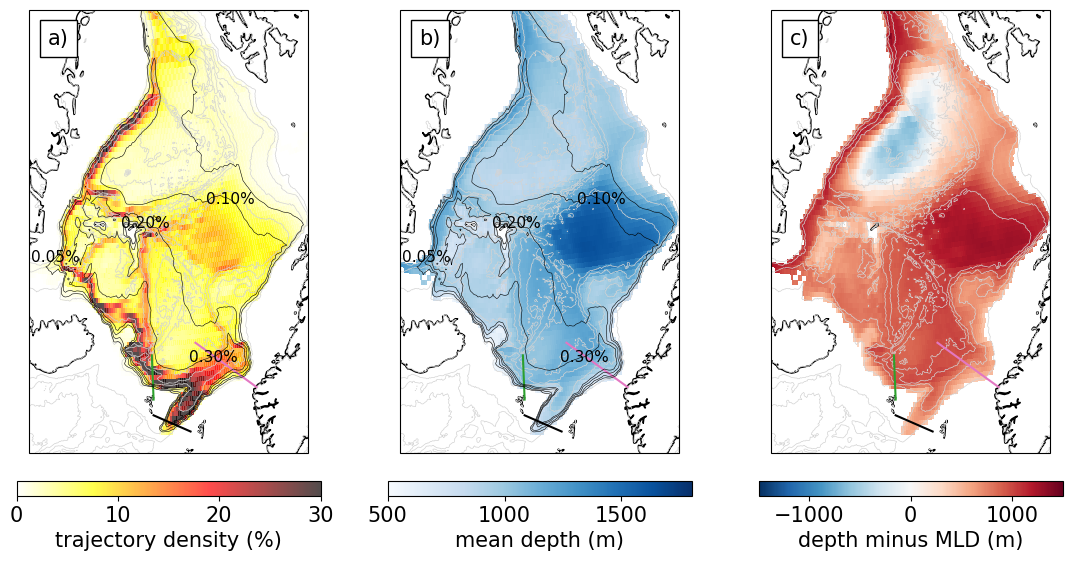

In [ ]:
# Projection
proj = ccrs.LambertConformal(central_longitude=-10, central_latitude=70)

# Create 3x1 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": proj})
ax1, ax2, ax3 = axes

#######################
# Map 1: trajectory density
#######################
ax1.set_extent([-20, 10, 59, 80], crs=ccrs.PlateCarree())
m1 = ax1.pcolormesh(
    lon,
    lat,
    heatmap_all,
    cmap="hot_r",
    vmin=0,
    vmax=30,
    alpha=0.7,
    transform=ccrs.PlateCarree(),
)
ax1.coastlines()
ax1.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    transform=ccrs.PlateCarree(),
)
ax1.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
ax1.plot([-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree())
ax1.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

# Overlay traffic intensity contours
cs = ax1.contour(
    heatmap_weighted.lon,
    heatmap_weighted.lat,
    heatmap_weighted * 1000,
    levels=[0.05, 0.1, 0.2, 0.3],
    colors="k",
    linewidths=0.4,
    transform=ccrs.PlateCarree(),
)
for i, level in enumerate(cs.levels):
    path = cs.collections[i].get_paths()[0]
    vertices = path.vertices
    idx = len(vertices) // 4
    lon_label, lat_label = vertices[idx]
    ax1.text(
        lon_label,
        lat_label,
        f"{level:.2f}%",
        transform=ccrs.PlateCarree(),
        fontsize=11,
        color="k",
        ha="center",
        va="center",
    )
fig.colorbar(m1, ax=ax1, orientation="horizontal", pad=0.05, shrink=0.3).set_label(
    "trajectory density (%)"
)
ax1.add_artist(AnchoredText("a)", prop=dict(size=15), frameon=True, loc="upper left"))

#######################
# Map 2: mean depth
#######################
ax2.set_extent([-20, 10, 59, 80], crs=ccrs.PlateCarree())
m2 = ax2.pcolormesh(
    lon,
    lat,
    msk * mean_depth.T,
    vmin=500,
    vmax=1800,
    cmap="Blues",
    transform=ccrs.PlateCarree(),
)
ax2.coastlines()
ax2.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    transform=ccrs.PlateCarree(),
)
ax2.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
ax2.plot([-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree())
ax2.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

# Overlay traffic intensity
cs2 = ax2.contour(
    heatmap_weighted.lon,
    heatmap_weighted.lat,
    heatmap_weighted,
    levels=[0.05, 0.1, 0.2, 0.3],
    colors="k",
    linewidths=0.4,
    transform=ccrs.PlateCarree(),
)
for i, level in enumerate(cs2.levels):
    path = cs2.collections[i].get_paths()[0]
    vertices = path.vertices
    idx = len(vertices) // 4
    lon_label, lat_label = vertices[idx]
    ax2.text(
        lon_label,
        lat_label,
        f"{level:.2f}%",
        transform=ccrs.PlateCarree(),
        fontsize=11,
        color="k",
        ha="center",
        va="center",
    )
fig.colorbar(m2, ax=ax2, orientation="horizontal", pad=0.05, shrink=0.3).set_label(
    "mean depth (m)"
)
ax2.add_artist(AnchoredText("b)", prop=dict(size=15), frameon=True, loc="upper left"))

#######################
# Map 3: depth minus MLD
#######################
ax3.set_extent([-20, 10, 59, 80], crs=ccrs.PlateCarree())
m3 = ax3.pcolormesh(
    mean_depth.lon_bin,
    mean_depth.lat_bin,
    (mean_depth.T - MLD_ann_max_mean_regridded) * msk,
    cmap="RdBu_r",
    vmin=-1500,
    vmax=1500,
    transform=ccrs.PlateCarree(),
)
ax3.coastlines()
ax3.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    transform=ccrs.PlateCarree(),
)
ax3.plot([5.5, -1], [62.24, 65.0], color="tab:pink", transform=ccrs.PlateCarree())
ax3.plot([-6.43, -6.43], [62.15, 64.5], color="tab:green", transform=ccrs.PlateCarree())
ax3.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())
fig.colorbar(m3, ax=ax3, orientation="horizontal", pad=0.05, shrink=0.3).set_label(
    "depth minus MLD (m)"
)
ax3.add_artist(AnchoredText("c)", prop=dict(size=15), frameon=True, loc="upper left"))
# Adjust spacing
fig.subplots_adjust(wspace=-0.8)  # decrease horizontal gap (default ~0.2)


#######################
# Adjust layout
#######################
plt.tight_layout()
# plt.savefig('Fig4_heatmap_depth',dpi=300, bbox_inches='tight')
plt.show()

## Figure 5

In [18]:
grouped_data = p.groupby("start_time")
grouped_datasets = {start_time: group for start_time, group in grouped_data}
grouped_values = list(grouped_datasets.values())

In [19]:
start_year = 1995
end_year = 2020

annual_data = {}

for year in range(start_year, end_year + 1):
    start_date = pd.Timestamp(f"{year}-01-01")
    end_date = pd.Timestamp(f"{year}-12-31")
    date_range = pd.date_range(start=start_date, end=end_date, freq="5D")
    start_index = (start_date - pd.Timestamp("1995-01-01")).days // 5  # '2003-01-01'
    end_index = (
        end_date - pd.Timestamp("1995-01-01")
    ).days // 5 + 1  # +1 to include the end date
    selected_values = grouped_values[start_index:end_index]
    concatenated_data = xr.concat(selected_values, dim="trajectory")
    annual_data[year] = concatenated_data

In [20]:
mean_temp_maps = {}

for year in tqdm.tqdm(range(1995, 2021)):
    temp_data = annual_data.get(year).temp
    lat, lon = rechunk_lat_lon(annual_data.get(year))
    mean_temp_maps[year] = get_mean_maps(temp_data, lat, lon).compute()

100%|██████████| 26/26 [03:33<00:00,  8.21s/it]


In [21]:
mean_salt_maps = {}

for year in tqdm.tqdm(range(1995, 2021)):
    salt_data = annual_data.get(year).salt
    lat, lon = rechunk_lat_lon(annual_data.get(year))
    mean_salt_maps[year] = get_mean_maps(salt_data, lat, lon).compute()

100%|██████████| 26/26 [03:30<00:00,  8.11s/it]


In [24]:
def concatenate_annual_data(mean_maps):
    years_to_concatenate = range(1995, 2021)
    data_arrays = []

    for year in years_to_concatenate:
        data_arrays.append(mean_maps.get(year))
    return data_arrays


overflow_temp_annual_means = (
    xr.concat(concatenate_annual_data(mean_temp_maps), dim="year")
    .assign_coords(year=("year", range(1995, 2021)))
    .transpose("year", "lat_bin", "lon_bin")
)
overflow_salt_annual_means = (
    xr.concat(concatenate_annual_data(mean_salt_maps), dim="year")
    .assign_coords(year=("year", range(1995, 2021)))
    .transpose("year", "lat_bin", "lon_bin")
)

In [25]:
def trends(x, y):
    y = y.values
    x = x.values
    SSH_dec_6_reshape = y.reshape(len(x), -1)

    num_lats, num_lons = y.shape[1:]

    trends = np.empty((num_lats, num_lons))
    p_values = np.empty((num_lats, num_lons))

    for i in range(num_lats):
        # print(i)
        for j in range(num_lons):
            # in linregress it's slope, inercept, r value, p value
            slope, _, _, p_value, _ = linregress(
                x, SSH_dec_6_reshape[:, i * num_lons + j]
            )
            trends[i, j] = slope
            p_values[i, j] = p_value
    trends_da = xr.DataArray(trends).rename({"dim_0": "lat_bin", "dim_1": "lon_bin"})
    p_values_da = xr.DataArray(p_values).rename(
        {"dim_0": "lat_bin", "dim_1": "lon_bin"}
    )
    return trends_da, p_values_da


def sig_test_95th(lagged_pval):
    sig_95th = np.less_equal(lagged_pval, 0.05)
    mask = np.ma.masked_invalid(lagged_pval[:, :])
    masked = np.ma.masked_where(np.ma.getmask(mask), sig_95th)
    return masked

In [28]:
trend_2003_2020_T = trends(
    overflow_temp_annual_means.year.sel(year=slice(2003, None)),
    overflow_temp_annual_means.sel(year=slice(2003, None)),
)

trend_2003_2020_S = trends(
    overflow_salt_annual_means.year.sel(year=slice(2003, None)),
    overflow_salt_annual_means.sel(year=slice(2003, None)),
)

In [29]:
lon, lat = trend_2003_2020_T[0].lon_bin, trend_2003_2020_T[0].lat_bin
mask = xr.where(heatmap_all > 0.5, 1, np.nan).rename(
    {"lat": "lat_bin", "lon": "lon_bin"}
)

In [30]:
plt.rcParams.update({"font.size": 10})

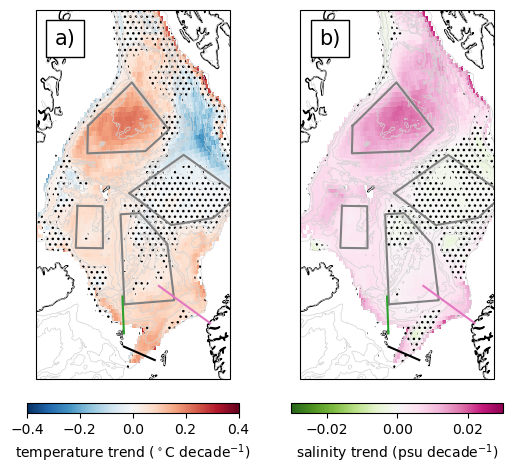

In [31]:
proj = ccrs.LambertConformal(central_longitude=-10, central_latitude=70)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), subplot_kw={"projection": proj})

# --- First map ---
# ax1.set_extent([-25, 9, 58, 82], crs=ccrs.PlateCarree())

ax1.set_extent([-18, 7, 59, 80], crs=ccrs.PlateCarree())
m1 = ax1.pcolormesh(
    mean_depth.lon_bin,
    mean_depth.lat_bin,
    trend_2003_2020_T[0] * 10 * mask,
    cmap="RdBu_r",
    vmin=-0.4,
    vmax=0.4,
    transform=ccrs.PlateCarree(),
)
ax1.coastlines()
ax1.contourf(
    mean_depth.lon_bin,
    mean_depth.lat_bin,
    sig_test_95th(trend_2003_2020_T[1]),
    [-0.232, 0.232],
    colors="none",
    hatches=["..."],
    transform=ccrs.PlateCarree(),
)
ax1.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)
fig.colorbar(m1, ax=ax1, orientation="horizontal", pad=0.05, shrink=0.36).set_label(
    "temperature trend ($^\circ$C decade$^{-1}$)"
)
ax1.plot(x_GSea, y_GSea, color="gray", label="GSea", transform=ccrs.PlateCarree())
ax1.plot(
    x_Lofoten, y_Lofoten, color="gray", label="Lofoten", transform=ccrs.PlateCarree()
)
ax1.plot(
    x_Iceland, y_Iceland, color="gray", label="Iceland", transform=ccrs.PlateCarree()
)
ax1.plot(
    x_Norwegian,
    y_Norwegian,
    color="gray",
    label="Norwegian",
    transform=ccrs.PlateCarree(),
)
ax1.plot(
    [5.5, -1],
    [62.24, 65.0],
    color="tab:pink",
    label="Svinoy section",
    transform=ccrs.PlateCarree(),
)
ax1.plot(
    [-6.43, -6.43],
    [62.15, 64.5],
    color="tab:green",
    label="N section",
    transform=ccrs.PlateCarree(),
)
ax1.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

# --- Second map ---
# ax2.set_extent([-25, 9, 58, 82], crs=ccrs.PlateCarree())
ax2.set_extent([-18, 7, 59, 80], crs=ccrs.PlateCarree())
m2 = ax2.pcolormesh(
    mean_depth.lon_bin,
    mean_depth.lat_bin,
    trend_2003_2020_S[0] * 10 * mask,
    cmap="PiYG_r",
    vmin=-0.03,
    vmax=0.03,
    transform=ccrs.PlateCarree(),
)
ax2.coastlines()
ax2.contourf(
    mean_depth.lon_bin,
    mean_depth.lat_bin,
    sig_test_95th(trend_2003_2020_S[1]),
    [-0.232, 0.232],
    colors="none",
    hatches=["..."],
    transform=ccrs.PlateCarree(),
)
ax2.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)
fig.colorbar(m2, ax=ax2, orientation="horizontal", pad=0.05, shrink=0.36).set_label(
    "salinity trend (psu decade$^{-1}$)"
)
ax2.plot(x_GSea, y_GSea, color="gray", label="GSea", transform=ccrs.PlateCarree())
ax2.plot(
    x_Lofoten, y_Lofoten, color="gray", label="Lofoten", transform=ccrs.PlateCarree()
)
ax2.plot(
    x_Iceland, y_Iceland, color="gray", label="Iceland", transform=ccrs.PlateCarree()
)
ax2.plot(
    x_Norwegian,
    y_Norwegian,
    color="gray",
    label="Norwegian",
    transform=ccrs.PlateCarree(),
)
ax2.plot(
    [5.5, -1],
    [62.24, 65.0],
    color="tab:pink",
    label="Svinoy section",
    transform=ccrs.PlateCarree(),
)
ax2.plot(
    [-6.43, -6.43],
    [62.15, 64.5],
    color="tab:green",
    label="N section",
    transform=ccrs.PlateCarree(),
)
# ax2.plot([-15, -11.95], [66.25, 68.7], color='blue', label='LN section', transform=ccrs.PlateCarree())
ax2.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

at = AnchoredText("a)", prop=dict(size=15), frameon=True, loc="upper left")
ax1.add_artist(at)

at = AnchoredText("b)", prop=dict(size=15), frameon=True, loc="upper left")
ax2.add_artist(at)

# Reduce horizontal space between maps
fig.subplots_adjust(wspace=-0.55)
# plt.savefig('Fig4_S_T_trends.png',dpi=300, bbox_inches='tight')
plt.show()

## Figure 6

In [34]:
# ''' Pprocess the ocean basins for temp and salt trends '''
# ds_Lofoten_overflows = process_ocean_basins(ds_overflows)['lofoten']
# ds_Iceland_overflows = process_ocean_basins(ds_overflows)['iceland']
# ds_Norwegian_overflows = process_ocean_basins(ds_overflows)['norwegian']
# ds_Greenland_overflows = process_ocean_basins(ds_overflows)['greenland']


# Greenland_basin_cross = filter_trajectories(process_ocean_basins(ds_overflows)['greenland'], p)
# Lofoten_basin_cross = filter_trajectories(process_ocean_basins(ds_overflows)['lofoten'], p)
# Iceland_basin_cross = filter_trajectories(process_ocean_basins(ds_overflows)['iceland'], p)
# Norwegian_basin_cross = filter_trajectories(process_ocean_basins(ds_overflows)['norwegian'], p)

# Greenland_masked = process_ocean_basins(Greenland_basin_cross['traj_line'])['greenland']
# Lofoten_masked = process_ocean_basins(Lofoten_basin_cross['traj_line'])['lofoten']
# Iceland_masked = process_ocean_basins(Iceland_basin_cross['traj_line'])['iceland']
# Norwegian_masked = process_ocean_basins(Norwegian_basin_cross['traj_line'])['norwegian']

# # temperature crossing
# Greenland_temp_ts = Greenland_masked.temp.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Lofoten_temp_ts = Lofoten_masked.temp.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Iceland_temp_ts = Iceland_masked.temp.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Norwegian_temp_ts = Norwegian_masked.temp.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()

# Greenland_temp_std = Greenland_masked.temp.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Lofoten_temp_std = Lofoten_masked.temp.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Iceland_temp_std = Iceland_masked.temp.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Norwegian_temp_std = Norwegian_masked.temp.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()


# # salinity crossing

# Greenland_salt_ts = Greenland_masked.salt.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Lofoten_salt_ts = Lofoten_masked.salt.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Iceland_salt_ts = Iceland_masked.salt.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Norwegian_salt_ts = Norwegian_masked.salt.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()

# # depths

# Greenland_depth_ts = Greenland_masked.z.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Lofoten_depth_ts = Lofoten_masked.z.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Iceland_depth_ts = Iceland_masked.z.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Norwegian_depth_ts = Norwegian_masked.z.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()

# # density

# Greenland_sigma0_ts = Greenland_masked.sigma0.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Lofoten_sigma0_ts = Lofoten_masked.sigma0.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Iceland_sigma0_ts = Iceland_masked.sigma0.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()
# Norwegian_sigma0_ts = Norwegian_masked.sigma0.groupby('start_time').mean(dim='trajectory').mean(dim='obs').compute()

# # --- SALT ---
# Greenland_salt_std = Greenland_masked.salt.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Lofoten_salt_std   = Lofoten_masked.salt.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Iceland_salt_std   = Iceland_masked.salt.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Norwegian_salt_std = Norwegian_masked.salt.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()

# # --- DEPTH ---
# Greenland_depth_std = Greenland_masked.z.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Lofoten_depth_std   = Lofoten_masked.z.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Iceland_depth_std   = Iceland_masked.z.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Norwegian_depth_std = Norwegian_masked.z.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()

# # --- DENSITY (sigma0) ---
# Greenland_sigma0_std = Greenland_masked.sigma0.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Lofoten_sigma0_std   = Lofoten_masked.sigma0.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Iceland_sigma0_std   = Iceland_masked.sigma0.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()
# Norwegian_sigma0_std = Norwegian_masked.sigma0.groupby('start_time').std(dim='trajectory').mean(dim='obs').compute()


# ds = xr.Dataset(
#     {
#         'Greenland_temp': Greenland_temp_ts,
#         'Lofoten_temp': Lofoten_temp_ts,
#         'Iceland_temp': Iceland_temp_ts,
#         'Norwegian_temp': Norwegian_temp_ts,
#         'Greenland_salt': Greenland_salt_ts,
#         'Lofoten_salt': Lofoten_salt_ts,
#         'Iceland_salt': Iceland_salt_ts,
#         'Norwegian_salt': Norwegian_salt_ts,
#         'Greenland_depth': Greenland_depth_ts,
#         'Lofoten_depth': Lofoten_depth_ts,
#         'Iceland_depth': Iceland_depth_ts,
#         'Norwegian_depth': Norwegian_depth_ts,
#         'Greenland_sigma0': Greenland_sigma0_ts,
#         'Lofoten_sigma0': Lofoten_sigma0_ts,
#         'Iceland_sigma0': Iceland_sigma0_ts,
#         'Norwegian_sigma0': Norwegian_sigma0_ts,
#     },
#     coords={
#         'start_time': Greenland_temp_ts['start_time'],  # Assuming all have the same time coordinate
#     }
# )

# # Add a description to the dataset
# ds.attrs['description'] = 'Temperature, salinity, depth, and density time series for Greenland, Lofoten, Iceland, and Norwegian regions.'

# #ds.to_netcdf('hydrography_basin_crossings_time_series_updated_extend.nc')

In [2]:
inpth = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/"
ds_basins = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_basin_crossings_time_series_updated_extend.nc"
)

Greenland_temp_ts = ds_basins.Greenland_temp
Lofoten_temp_ts = ds_basins.Lofoten_temp
Iceland_temp_ts = ds_basins.Iceland_temp
Norwegian_temp_ts = ds_basins.Norwegian_temp

Greenland_salt_ts = ds_basins.Greenland_salt
Lofoten_salt_ts = ds_basins.Lofoten_salt
Iceland_salt_ts = ds_basins.Iceland_salt
Norwegian_salt_ts = ds_basins.Norwegian_salt

Greenland_depth_ts = ds_basins.Greenland_depth
Lofoten_depth_ts = ds_basins.Lofoten_depth
Iceland_depth_ts = ds_basins.Iceland_depth
Norwegian_depth_ts = ds_basins.Norwegian_depth

Greenland_sigma0_ts = ds_basins.Greenland_sigma0
Lofoten_sigma0_ts = ds_basins.Lofoten_sigma0
Iceland_sigma0_ts = ds_basins.Iceland_sigma0
Norwegian_sigma0_ts = ds_basins.Norwegian_sigma0

Greenland_temp_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_greenland_basin_origin_time_series_stdev.nc"
).Greenland_temp_std.values
Lofoten_temp_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_lofoten_basin_origin_time_series_stdev.nc"
).Lofoten_temp_std.values
Iceland_temp_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_iceland_basin_origin_time_series_stdev.nc"
).Iceland_temp_std.values

Greenland_salt_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_greenland_basin_origin_time_series_stdev.nc"
).Greenland_salt_std.values
Lofoten_salt_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_lofoten_basin_origin_time_series_stdev.nc"
).Lofoten_salt_std.values
Iceland_salt_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_iceland_basin_origin_time_series_stdev.nc"
).Iceland_salt_std.values

Greenland_depth_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_greenland_basin_origin_time_series_stdev.nc"
).Greenland_depth_std.values
Lofoten_depth_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_lofoten_basin_origin_time_series_stdev.nc"
).Lofoten_depth_std.values
Iceland_depth_std = xr.open_dataset(
    inpth
    + "basins_crossings_data/hydrography_iceland_basin_origin_time_series_stdev.nc"
).Iceland_depth_std.values

Norwegian_temp_std = 0.47719675
Norwegian_salt_std = 0.01090654
Norwegian_depth_std = 395.81312001

In [3]:
def weighted_mean(data):
    gb_area = data.dx * data.dz
    numerator = (
        (data * gb_area).squeeze().sum(["z", "c"])
    )  # if want to depth average over range of depths, use native grid! .isel(z=slice...).then sum over z, y, and x
    denominator = (gb_area).sum(["c", "z"]).squeeze()
    div = numerator / denominator
    return div


def weighted_mean_sigma0(S_sigma0, data):
    gb_area = data.dx * data.dz
    numerator = (
        (S_sigma0 * gb_area).squeeze().sum(["z", "c"])
    )  # if want to depth average over range of depths, use native grid! .isel(z=slice...).then sum over z, y, and x
    denominator = (gb_area).sum(["c", "z"]).squeeze()
    div = numerator / denominator
    return div


S = xr.open_dataset("/gxfs_work/geomar/smomw452/GLORYS12/Data/S_section.nc")
S_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        S.vosaline,
        S.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
S_overflow = S.where(S_sigma0 > 28)

## N section

N = xr.open_dataset("/gxfs_work/geomar/smomw452/GLORYS12/Data/N_section.nc")
N_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        N.vosaline,
        N.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
N_overflow = N.where((N_sigma0 > 27.985))

In [4]:
plt.rcParams.update({"font.size": 14})

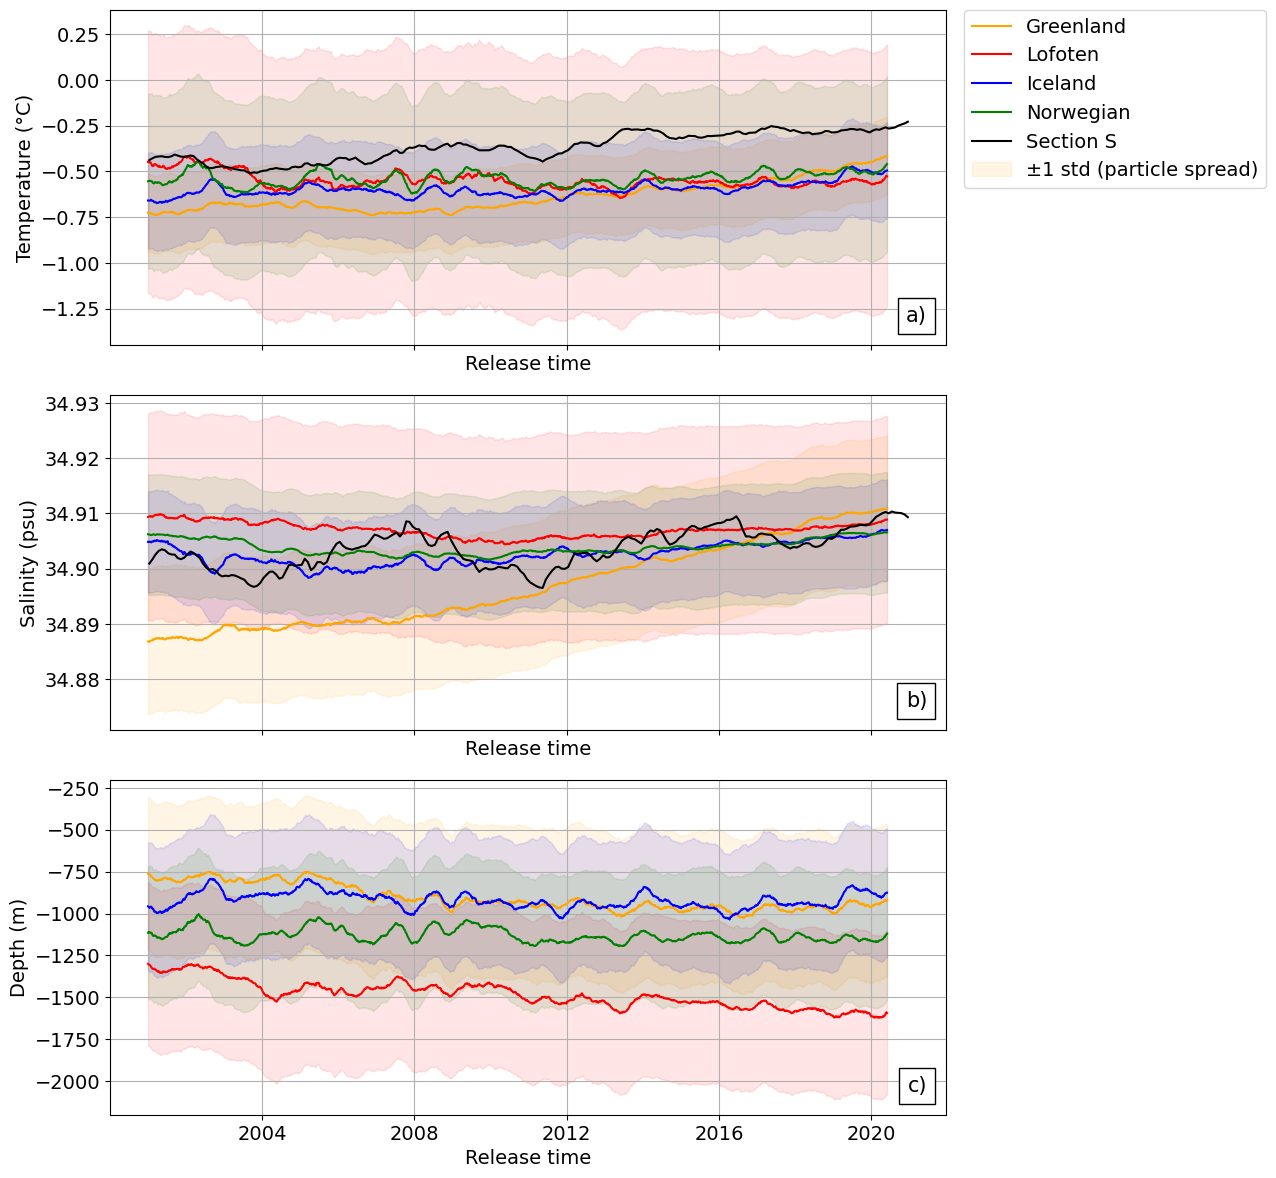

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(13, 12), sharex=True)


Greenland_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Greenland", color="orange")
Lofoten_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Lofoten", color="red")
Iceland_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Iceland", color="blue")
Norwegian_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Norwegian", color="green")
weighted_mean(S_overflow).votemper.rolling(time_counter=30).mean(
    dim="time_counter"
).sel(time_counter=slice("2001-01-01", None)).plot(
    ax=axs[0], label="Section S", color="k"
)

axs[0].fill_between(
    Greenland_temp_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Greenland_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Greenland_temp_std,
    Greenland_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Greenland_temp_std,
    color="orange",
    alpha=0.1,
    label="±1 std (particle spread)",
)


axs[0].fill_between(
    Lofoten_temp_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Lofoten_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Lofoten_temp_std,
    Lofoten_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Lofoten_temp_std,
    color="red",
    alpha=0.1,
)

axs[0].fill_between(
    Iceland_temp_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Iceland_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Iceland_temp_std,
    Iceland_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Iceland_temp_std,
    color="blue",
    alpha=0.1,
)

axs[0].fill_between(
    Norwegian_temp_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Norwegian_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Norwegian_temp_std,
    Norwegian_temp_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Norwegian_temp_std,
    color="green",
    alpha=0.1,
)

axs[0].set_ylabel("Temperature (°C)")
at = AnchoredText("a)", prop=dict(size=15), frameon=True, loc="lower right")
axs[0].add_artist(at)
axs[0].legend(loc="upper left", bbox_to_anchor=(1.01, 1.03))
axs[0].set_xlabel("Release time")
axs[0].grid()


Greenland_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Greenland", color="orange")
Lofoten_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Lofoten", color="red")
Iceland_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Iceland", color="blue")
Norwegian_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Norwegian", color="green")
weighted_mean(S_overflow).vosaline.rolling(time_counter=30).mean(
    dim="time_counter"
).sel(time_counter=slice("2001-01-01", None)).plot(
    ax=axs[1], label="Section S", color="k"
)
axs[1].set_ylabel("Salinity (psu)")
at = AnchoredText("b)", prop=dict(size=15), frameon=True, loc="lower right")
axs[1].add_artist(at)
axs[1].set_xlabel("Release time")
axs[1].grid()

axs[1].fill_between(
    Greenland_salt_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Greenland_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Greenland_salt_std,
    Greenland_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Greenland_salt_std,
    color="orange",
    alpha=0.1,
    label="±1 std (particle spread)",
)

axs[1].fill_between(
    Lofoten_salt_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Lofoten_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Lofoten_salt_std,
    Lofoten_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Lofoten_salt_std,
    color="red",
    alpha=0.1,
)

axs[1].fill_between(
    Iceland_salt_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Iceland_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Iceland_salt_std,
    Iceland_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Iceland_salt_std,
    color="blue",
    alpha=0.1,
)

axs[1].fill_between(
    Norwegian_salt_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    Norwegian_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Norwegian_salt_std,
    Norwegian_salt_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Norwegian_salt_std,
    color="green",
    alpha=0.1,
)


(
    -Greenland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Greenland", color="orange")
(
    -Lofoten_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Lofoten", color="red")
(
    -Iceland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Iceland", color="blue")
(
    -Norwegian_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Norwegian", color="green")
axs[2].set_xlabel("Release time")
axs[2].set_ylabel("Depth (m)")
at = AnchoredText("c)", prop=dict(size=15), frameon=True, loc="lower right")
axs[2].add_artist(at)
axs[2].grid()

axs[2].fill_between(
    Greenland_depth_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    -Greenland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Greenland_depth_std,
    -Greenland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Greenland_depth_std,
    color="orange",
    alpha=0.1,
    label="±1 std (particle spread)",
)

axs[2].fill_between(
    Lofoten_depth_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    -Lofoten_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Lofoten_depth_std,
    -Lofoten_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Lofoten_depth_std,
    color="red",
    alpha=0.1,
)

axs[2].fill_between(
    Iceland_depth_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    -Iceland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Iceland_depth_std,
    -Iceland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Iceland_depth_std,
    color="blue",
    alpha=0.1,
)

axs[2].fill_between(
    Norwegian_depth_ts.start_time.sel(start_time=slice("2001-01-01", None)),
    -Norwegian_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    - Norwegian_depth_std,
    -Norwegian_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
    + Norwegian_depth_std,
    color="green",
    alpha=0.1,
)


plt.tight_layout()
# plt.savefig('Fig6_basins_time_series_vertical_v2.png', dpi=300, bbox_inches='tight')
plt.show()

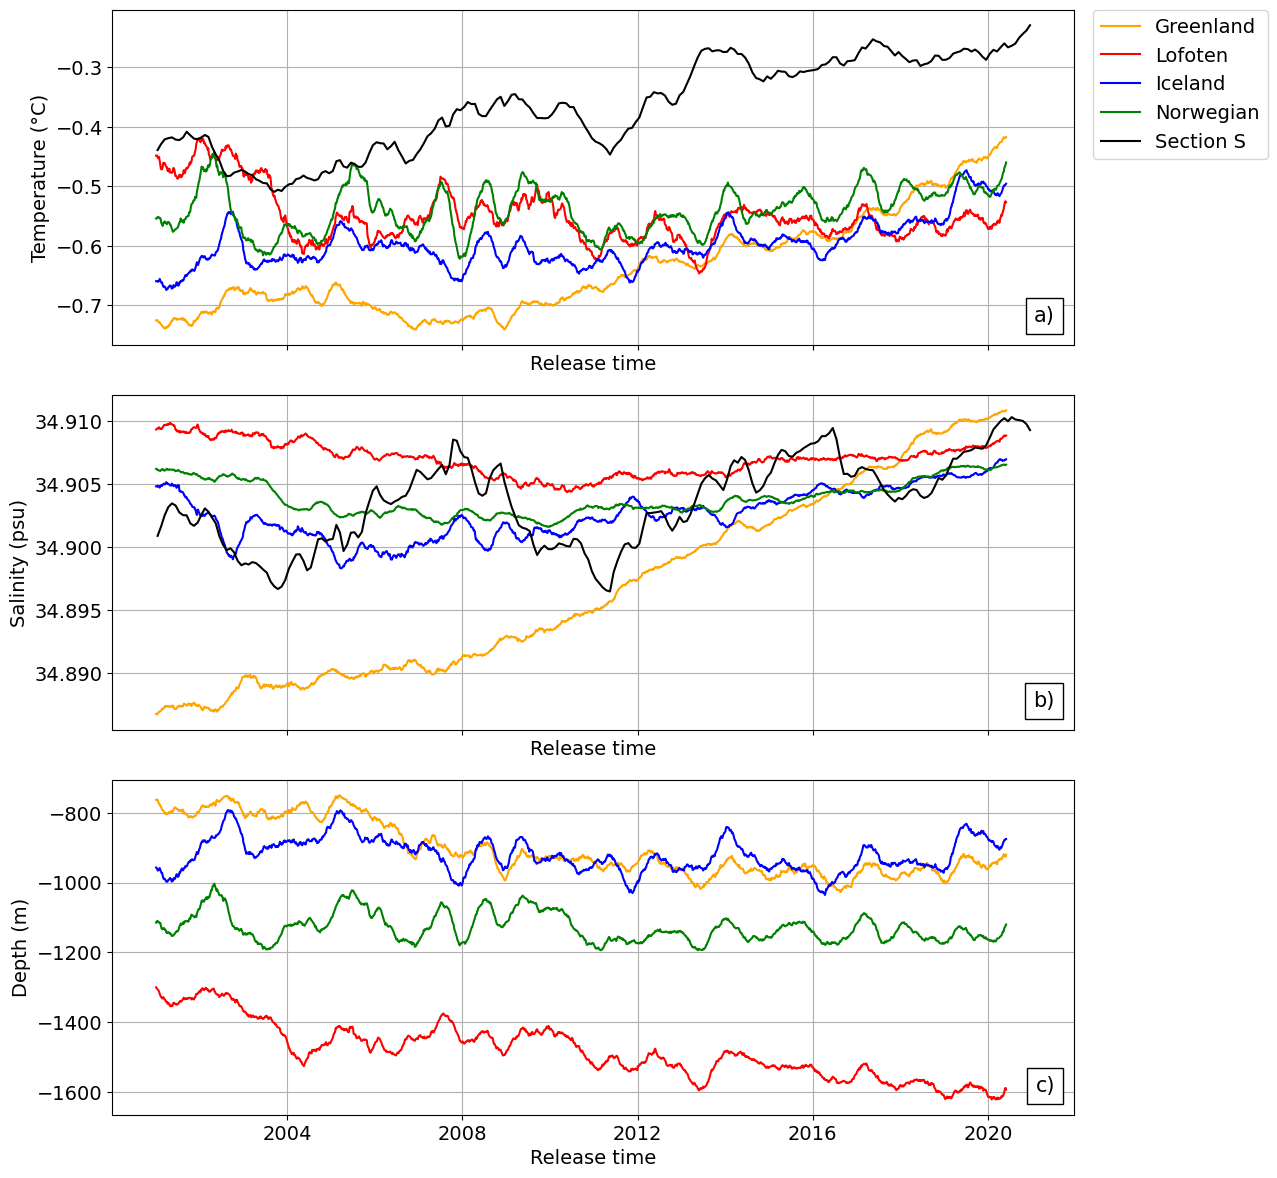

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(13, 12), sharex=True)


Greenland_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Greenland", color="orange")
Lofoten_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Lofoten", color="red")
Iceland_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Iceland", color="blue")
Norwegian_temp_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[0], label="Norwegian", color="green")
weighted_mean(S_overflow).votemper.rolling(time_counter=30).mean(
    dim="time_counter"
).sel(time_counter=slice("2001-01-01", None)).plot(
    ax=axs[0], label="Section S", color="k"
)


axs[0].set_ylabel("Temperature (°C)")
at = AnchoredText("a)", prop=dict(size=15), frameon=True, loc="lower right")
axs[0].add_artist(at)
axs[0].legend(loc="upper left", bbox_to_anchor=(1.01, 1.03))
axs[0].set_xlabel("Release time")
axs[0].grid()


Greenland_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Greenland", color="orange")
Lofoten_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Lofoten", color="red")
Iceland_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Iceland", color="blue")
Norwegian_salt_ts.rolling(start_time=30).mean(dim="start_time").sel(
    start_time=slice("2001-01-01", None)
).plot(ax=axs[1], label="Norwegian", color="green")
weighted_mean(S_overflow).vosaline.rolling(time_counter=30).mean(
    dim="time_counter"
).sel(time_counter=slice("2001-01-01", None)).plot(
    ax=axs[1], label="Section S", color="k"
)
axs[1].set_ylabel("Salinity (psu)")
at = AnchoredText("b)", prop=dict(size=15), frameon=True, loc="lower right")
axs[1].add_artist(at)
axs[1].set_xlabel("Release time")
axs[1].grid()

(
    -Greenland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Greenland", color="orange")
(
    -Lofoten_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Lofoten", color="red")
(
    -Iceland_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Iceland", color="blue")
(
    -Norwegian_depth_ts.rolling(start_time=30)
    .mean(dim="start_time")
    .sel(start_time=slice("2001-01-01", None))
).plot(ax=axs[2], label="Norwegian", color="green")
axs[2].set_xlabel("Release time")
axs[2].set_ylabel("Depth (m)")
at = AnchoredText("c)", prop=dict(size=15), frameon=True, loc="lower right")
axs[2].add_artist(at)
axs[2].grid()


plt.tight_layout()
plt.savefig("Fig6_basins_time_series_vertical_v2.png", dpi=300, bbox_inches="tight")
plt.show()